# Model Test Notebook

## Imports

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam

from LSTM_Model_Training import (
    get_config,
    preprocess_aachen_dataset,
    plot_training_history,
    plot_predictions_vs_actual,
    plot_residuals,
    save_model_structure_and_weights,
    load_model_structure_and_weights,
    get_unique_model_name
)

## Load data

In [ ]:
filename = "/Users/sigurdgjerdingen/Student/Master kode/Master_Herstad-Gjerdingen/data/Degradation_Prediction_Dataset_ISEA.mat"

#  Load configuration
config = get_config()

# Load and preprocess the Aachen dataset
aachen_data = preprocess_aachen_dataset(
    filename,
    eol_capacity=0.65,
    test_cell_count=3,
    random_state=52,
    log_transform=False,
)

# Extract the preprocessed data
X_train_lstm = aachen_data["X_train"]
X_val_lstm = aachen_data["X_val"]
X_test_lstm = aachen_data["X_test"]
y_train = aachen_data["y_train"]
y_val = aachen_data["y_val"]
y_test = aachen_data["y_test"]
y_max = aachen_data["y_max"]


## Linear model

In [51]:
# The target variable is the remaining useful life (RUL). This is the number of cycles until the maximum capacity of the battery falls below 80% of its initial capacity, and will be called EOL80.
#
# The EOL80 is calculated as follows:
# Calculate the value of the capacity at EOL80, which is 80% of the initial capacity.
# For each cycle, calculate the capacity of the battery.
# The EOL80 is the cycle when the capacity of the battery falls below the value calculated in step 1. We can find the cycle number in the column Target_Cycle_Expanded, and the values of the capacity in the column Target_expanded

In [52]:
X_train_lstm.shape, X_val_lstm.shape, X_test_lstm.shape, y_train.shape, y_val.shape, y_test.shape, y_max

((7998, 288, 1), (2000, 288, 1), (688, 288, 1), (7998,), (2000,), (688,), 1495)

In [53]:
# Define the model for linear regression on time series input of shape (272, 1)
model = Sequential()

model = Sequential([
    Input(shape=(288,1)),  # expect input with shape (272, 1)
    Flatten(),             # flatten to (272,)
    Dense(1, activation="linear")     # linear regression: output = w.x + b
])

model.compile(optimizer=Adam(learning_rate=0.005), loss="mse", metrics=["mae"])
model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_10 (Flatten)            │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289 (1.13 KB)

 Trainable params: 289 (1.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 0.0203 - mae: 0.1089 - val_loss: 0.0099 - val_mae: 0.0801
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 0.0099 - mae: 0.0807 - val_loss: 0.0102 - val_mae: 0.0811
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 0.0091 - mae: 0.0771 - val_loss: 0.0076 - val_mae: 0.0733
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 0.0087 - mae: 0.0763 - val_loss: 0.0084 - val_mae: 0.0778
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 0.0117 - mae: 0.0876 - val_loss: 0.0194 - val_mae: 0.1173
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 0.0094 - mae: 0.0782 - val_loss: 0.0076 - val_mae: 0.0717
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 0.0089 - mae: 0.0765 - val_loss: 0.0080 - val_mae: 0.0737
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 0.0090 - mae: 0.0770 - val_loss: 0.0082 - val_mae: 0.0761
Epoch 9/100
250/250 ━━━━━━━━━━━━

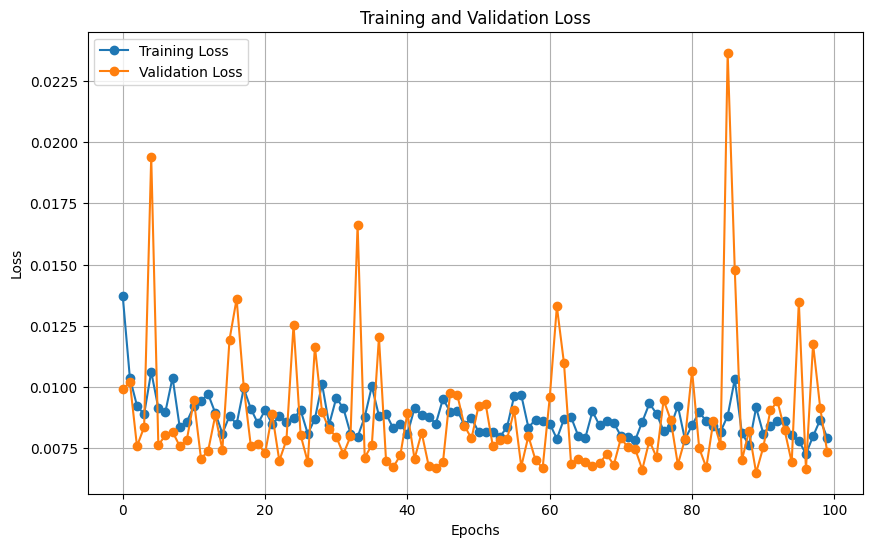

In [54]:
# Train the model
history = model.fit(
    X_train_lstm,
    y_train,
    validation_data=(X_val_lstm, y_val),
    epochs=100,
    batch_size=32,
    verbose=1,
)

# Plot the training history
plot_training_history(history)

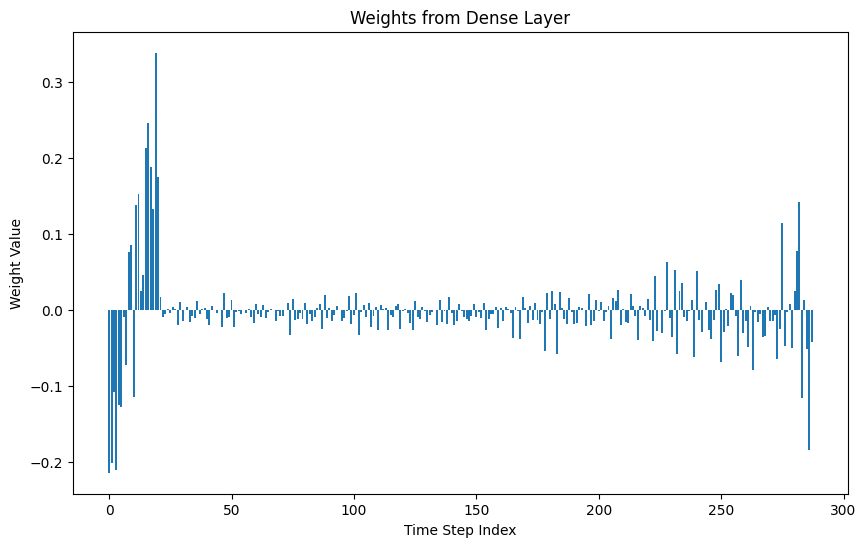

In [57]:
import matplotlib.pyplot as plt

# Retrieve the weights and bias from the Dense layer (layer index 1)
weights, bias = model.layers[1].get_weights()

# Flatten the weights for plotting (shape: (272, 1) -> (272,))
weights = weights.flatten()

# Plot the weights as a bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(weights)), weights)
plt.xlabel("Time Step Index")
plt.ylabel("Weight Value")
plt.title("Weights from Dense Layer")
plt.show()

In [58]:
# Evaluate on the test set
test_loss, test_mae = model.evaluate(X_test_lstm, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

# Rescaled mae to the original scale
rescaled_mae = test_mae * y_max
print(f"Rescaled Test MAE: {rescaled_mae}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 0.0017 - mae: 0.0236   
Test Loss: 0.003231025766581297
Test MAE: 0.03837178647518158
Rescaled Test MAE: 57.36582078039646


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step


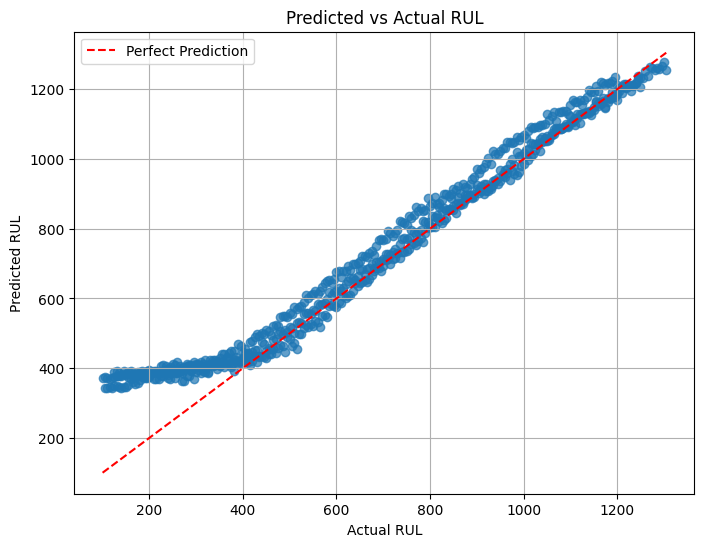

In [59]:
# Make predictions on the test set
y_pred = model.predict(X_test_lstm)

# Rescale predictions back to the original range
y_pred_rescaled = y_pred.flatten() * y_max
y_test_rescaled = y_test * y_max

# Plot predictions vs actual
plot_predictions_vs_actual(y_test_rescaled, y_pred_rescaled)

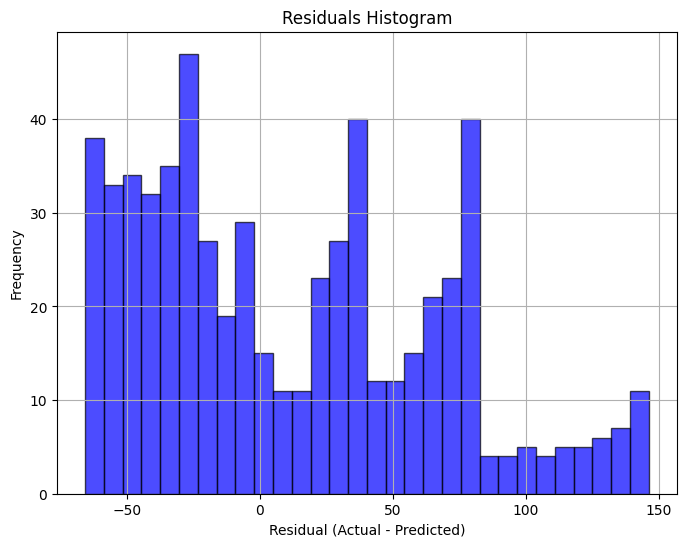

In [45]:
# Plot residuals
plot_residuals(y_test_rescaled, y_pred_rescaled)

## LSTM Model

In [39]:
model = Sequential([
    Masking(mask_value=0.0, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    LSTM(64, activation='relu', return_sequences=False),  # Fewer units
    Dropout(0.2),
    Dense(24, activation='relu'),  # Simpler Dense layer
    Dense(1)  # Output layer for RUL80
])


optimizer = Adam(learning_rate=0.01, clipnorm=1.0)  # Lower learning rate with gradient clipping


# Compile the model
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Display the model summary
model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_5 (Masking)             │ (None, 272, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,481 (72.19 KB)

 Trainable params: 18,481 (72.19 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Train the model
history = model.fit(
    X_train_lstm, y_train,
    validation_data=(X_val_lstm, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)


Epoch 1/20


225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 0.0209 - mae: 0.0948 - val_loss: 0.0047 - val_mae: 0.0497
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0058 - mae: 0.0581 - val_loss: 0.0052 - val_mae: 0.0540
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0051 - mae: 0.0547 - val_loss: 0.0046 - val_mae: 0.0506
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.0052 - mae: 0.0550 - val_loss: 0.0040 - val_mae: 0.0480
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 0.0051 - mae: 0.0549 - val_loss: 0.0042 - val_mae: 0.0485
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 0.0047 - mae: 0.0520 - val_loss: 0.0041 - val_mae: 0.0492
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 0.0048 - mae: 0.0531 - val_loss: 0.0057 - val_mae: 0.0539
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 0.0049 - mae: 0.0530 - val_loss: 0.0046 - val_mae: 0.0495
Epoch 9/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/st

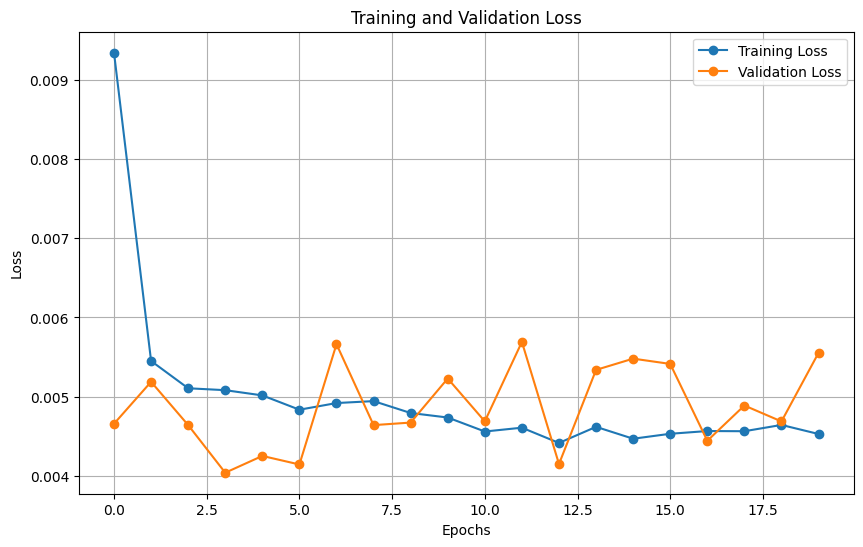

In [41]:
# Plot the training history
plot_training_history(history)

In [42]:
# Evaluate on the test set
test_loss, test_mae = model.evaluate(X_test_lstm, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0037 - mae: 0.0512
Test Loss: 0.0019856418948620558
Test MAE: 0.037188854068517685


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


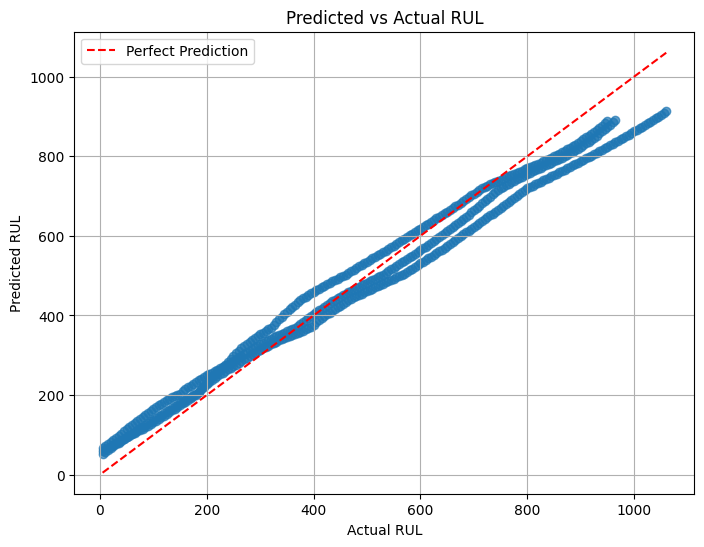

In [43]:
# Make predictions on the test set
y_pred = model.predict(X_test_lstm)

# Rescale predictions back to the original range
y_pred_rescaled = y_pred.flatten() * y_max
y_test_rescaled = y_test * y_max

# Plot predictions vs actual
plot_predictions_vs_actual(y_test_rescaled, y_pred_rescaled)

In [80]:
import pandas as pd

# Create a DataFrame to compare actual and predicted RUL80
results = pd.DataFrame({
    "Actual RUL80": y_test_rescaled,
    "Predicted RUL80": y_pred_rescaled
})
print(results.head())


   Actual RUL80  Predicted RUL80
0        1060.0       994.677917
1        1055.0       990.021057
2        1050.0       985.319702
3        1045.0       980.620056
4        1040.0       975.956604


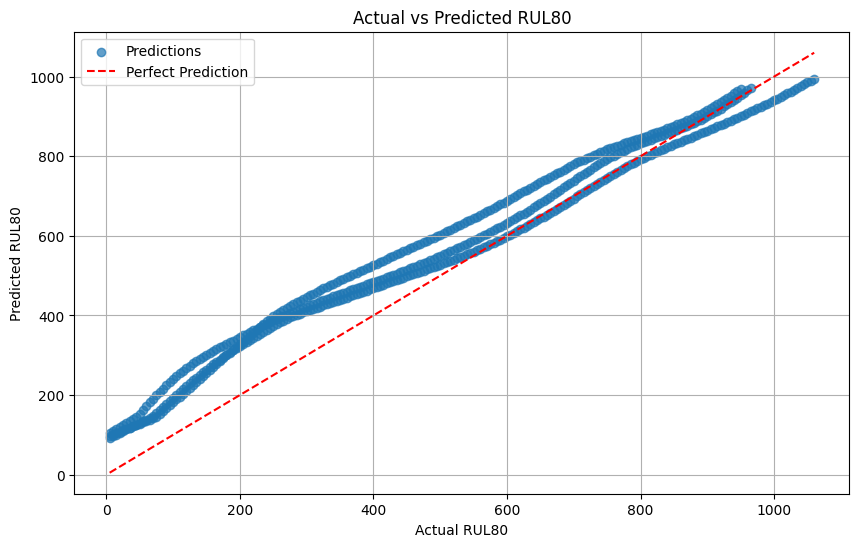

In [81]:
import matplotlib.pyplot as plt

# Scatter plot of Actual vs Predicted RUL80
plt.figure(figsize=(10, 6))
plt.scatter(y_test_rescaled, y_pred_rescaled, alpha=0.7, label='Predictions')
plt.plot([y_test_rescaled.min(), y_test_rescaled.max()], 
         [y_test_rescaled.min(), y_test_rescaled.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual RUL80")
plt.ylabel("Predicted RUL80")
plt.title("Actual vs Predicted RUL80")
plt.legend()
plt.grid(True)
plt.show()


In [82]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")


MAE: 71.80581691966337
RMSE: 85.05666738122457


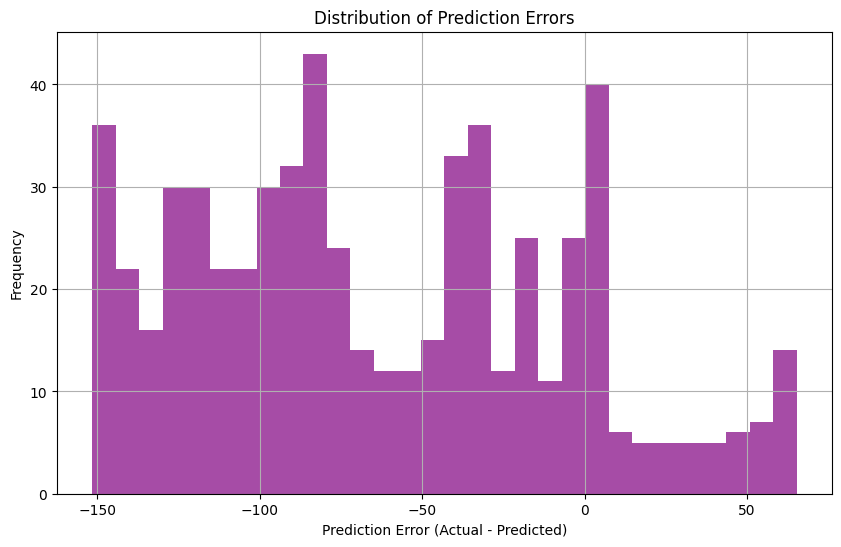

In [83]:
# Error distribution
errors = y_test_rescaled - y_pred_rescaled
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, alpha=0.7, color='purple')
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.grid(True)
plt.show()


In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential([
    # Masking layer to ignore padded zeros
    Masking(mask_value=0.0, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    
    # First LSTM layer with return_sequences=True for stacking
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.3),  # Slightly higher dropout to prevent overfitting
    
    # Second LSTM layer for extracting final sequence representation
    LSTM(32, activation='tanh', return_sequences=False),
    Dropout(0.2),
    
    # Fully connected layers
    Dense(16, activation='relu'),
    Dense(1)  # Output layer for RUL80
])

# Use a lower learning rate for stability and gradient clipping
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)

# Compile the model with Mean Absolute Error (MAE) as a metric
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Display the model summary
model.summary()


/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_11 (Masking)            │ (None, 272, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 272, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 272, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

In [86]:
# Train the model
history = model.fit(
    X_train_lstm, y_train,
    validation_data=(X_val_lstm, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)


Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 28s 117ms/step - loss: 0.0292 - mae: 0.1177 - val_loss: 0.0046 - val_mae: 0.0486
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - loss: 0.0066 - mae: 0.0601 - val_loss: 0.0041 - val_mae: 0.0477
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 26s 118ms/step - loss: 0.0055 - mae: 0.0558 - val_loss: 0.0040 - val_mae: 0.0481
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 27s 118ms/step - loss: 0.0054 - mae: 0.0553 - val_loss: 0.0050 - val_mae: 0.0495
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 27s 119ms/step - loss: 0.0048 - mae: 0.0522 - val_loss: 0.0043 - val_mae: 0.0478
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 27s 119ms/step - loss: 0.0051 - mae: 0.0539 - val_loss: 0.0040 - val_mae: 0.0483
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 27s 118ms/step - loss: 0.0051 - mae: 0.0541 - val_loss: 0.0047 - val_mae: 0.0485
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 27s 118ms/step - loss: 0.0046 - mae: 0.0517 - val_loss: 0.0041 - val_mae: 0.0496
Epoch 9/20
225/225 ━━━━━━━━━━━━━

In [87]:
# Evaluate on the test set
test_loss, test_mae = model.evaluate(X_test_lstm, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 9.9151e-04 - mae: 0.0261
Test Loss: 0.0010462866630405188
Test MAE: 0.026195749640464783


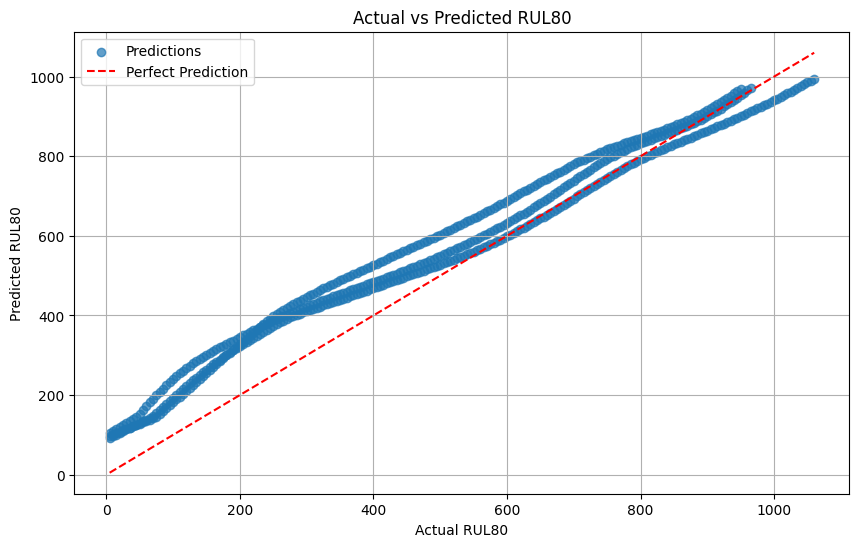

In [88]:
import matplotlib.pyplot as plt

# Scatter plot of Actual vs Predicted RUL80
plt.figure(figsize=(10, 6))
plt.scatter(y_test_rescaled, y_pred_rescaled, alpha=0.7, label='Predictions')
plt.plot([y_test_rescaled.min(), y_test_rescaled.max()], 
         [y_test_rescaled.min(), y_test_rescaled.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual RUL80")
plt.ylabel("Predicted RUL80")
plt.title("Actual vs Predicted RUL80")
plt.legend()
plt.grid(True)
plt.show()


In [93]:
import pandas as pd

# Create a DataFrame to compare actual and predicted RUL80
results = pd.DataFrame({
    "Actual RUL80": y_test_rescaled,
    "Predicted RUL80": y_pred_rescaled,
    "Difference": y_test_rescaled - y_pred_rescaled
})
print(results.head())


   Actual RUL80  Predicted RUL80  Difference
0        1060.0       994.677917   65.322083
1        1055.0       990.021057   64.978943
2        1050.0       985.319702   64.680298
3        1045.0       980.620056   64.379944
4        1040.0       975.956604   64.043396


In [94]:
results

,Actual RUL80,Predicted RUL80,Difference
0,1060.0,994.677917,65.322083
1,1055.0,990.021057,64.978943
2,1050.0,985.319702,64.680298
3,1045.0,980.620056,64.379944
4,1040.0,975.956604,64.043396
...,...,...,...
590,25.0,111.729118,-86.729118
591,20.0,108.255661,-88.255661
592,15.0,104.721008,-89.721008
593,10.0,101.116631,-91.116631


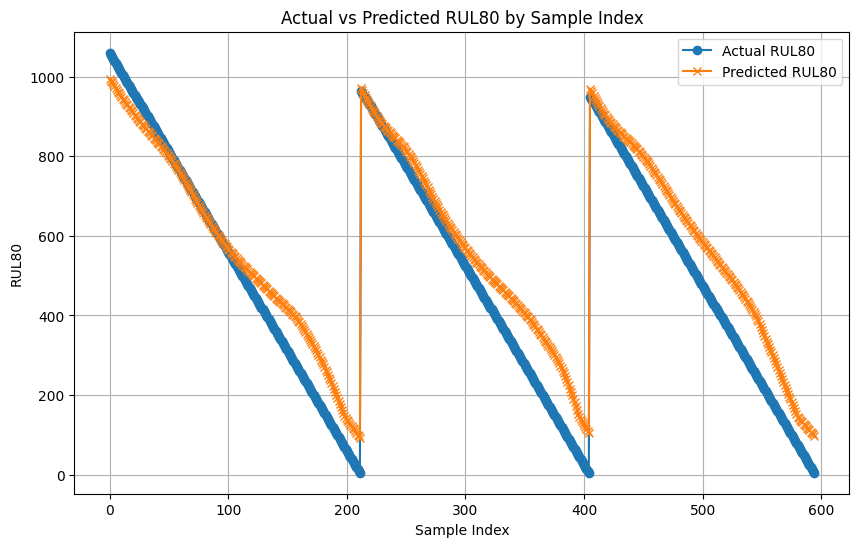

In [95]:
# Plot results as a function of sample index
plt.figure(figsize=(10, 6))
plt.plot(results.index, results["Actual RUL80"], label="Actual RUL80", marker='o')
plt.plot(results.index, results["Predicted RUL80"], label="Predicted RUL80", marker='x')
plt.xlabel("Sample Index")
plt.ylabel("RUL80")
plt.title("Actual vs Predicted RUL80 by Sample Index")
plt.legend()
plt.grid(True)
plt.show()

In [96]:
# # Define thresholds for life phases
early_threshold = 800
mid_threshold = 400

# Early-life samples
early_train = df_train[df_train["RUL80"] > early_threshold]
early_val = df_val[df_val["RUL80"] > early_threshold]
early_test = df_test[df_test["RUL80"] > early_threshold]

# Mid-life samples
mid_train = df_train[(df_train["RUL80"] > mid_threshold) & (df_train["RUL80"] <= early_threshold)]
mid_val = df_val[(df_val["RUL80"] > mid_threshold) & (df_val["RUL80"] <= early_threshold)]
mid_test = df_test[(df_test["RUL80"] > mid_threshold) & (df_test["RUL80"] <= early_threshold)]

# Late-life samples
late_train = df_train[df_train["RUL80"] <= mid_threshold]
late_val = df_val[df_val["RUL80"] <= mid_threshold]
late_test = df_test[df_test["RUL80"] <= mid_threshold]


In [97]:
def preprocess_data(data, max_sequence_length, scaler=None):
    history = data["History"].tolist()
    rul = np.array(data["RUL80"])

    # Normalize history data
    if scaler is None:
        scaler = MinMaxScaler()
        all_histories = np.concatenate([np.array(h) for h in history])
        scaler.fit(all_histories.reshape(-1, 1))
    
    history_normalized = [scaler.transform(np.array(h).reshape(-1, 1)).flatten() for h in history]
    
    # Pad sequences
    X_padded = pad_sequences(history_normalized, maxlen=max_sequence_length, padding='post', dtype='float32')
    X = X_padded[..., np.newaxis]  # Add feature dimension
    
    return X, rul, scaler

# Preprocess each phase
max_sequence_length = 1000  # Adjust based on your data

# Early-life
X_early_train, y_early_train, scaler_early = preprocess_data(early_train, max_sequence_length)
X_early_val, y_early_val, _ = preprocess_data(early_val, max_sequence_length, scaler_early)
X_early_test, y_early_test, _ = preprocess_data(early_test, max_sequence_length, scaler_early)

# Mid-life
X_mid_train, y_mid_train, scaler_mid = preprocess_data(mid_train, max_sequence_length)
X_mid_val, y_mid_val, _ = preprocess_data(mid_val, max_sequence_length, scaler_mid)
X_mid_test, y_mid_test, _ = preprocess_data(mid_test, max_sequence_length, scaler_mid)

# Late-life
X_late_train, y_late_train, scaler_late = preprocess_data(late_train, max_sequence_length)
X_late_val, y_late_val, _ = preprocess_data(late_val, max_sequence_length, scaler_late)
X_late_test, y_late_test, _ = preprocess_data(late_test, max_sequence_length, scaler_late)


In [103]:
# Find the min and max RUL80 for each phase
early_min, early_max = y_early_train.min(), y_early_train.max()
mid_min, mid_max = y_mid_train.min(), y_mid_train.max()
late_min, late_max = y_late_train.min(), y_late_train.max()

# Normalize target values for each phase
y_early_train = (y_early_train - early_min) / (early_max - early_min)
y_early_val = (y_early_val - early_min) / (early_max - early_min)
y_early_test = (y_early_test - early_min) / (early_max - early_min)

y_mid_train = (y_mid_train - mid_min) / (mid_max - mid_min)
y_mid_val = (y_mid_val - mid_min) / (mid_max - mid_min)
y_mid_test = (y_mid_test - mid_min) / (mid_max - mid_min)

y_late_train = (y_late_train - late_min) / (late_max - late_min)
y_late_val = (y_late_val - late_min) / (late_max - late_min)
y_late_test = (y_late_test - late_min) / (late_max - late_min)

# Verify normalization ranges
print("Normalized Early-life RUL range:", y_early_train.min(), "-", y_early_train.max())
print("Normalized Mid-life RUL range:", y_mid_train.min(), "-", y_mid_train.max())
print("Normalized Late-life RUL range:", y_late_train.min(), "-", y_late_train.max())


Normalized Early-life RUL range: 0.0 - 1.0
Normalized Mid-life RUL range: 0.0 - 1.0
Normalized Late-life RUL range: 0.0 - 1.0


In [104]:
def build_model():
    model = Sequential([
        Masking(mask_value=0.0, input_shape=(max_sequence_length, 1)),
        LSTM(32, activation='tanh', return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)  # Single output
    ])
    model.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss='mse', metrics=['mae'])
    return model

# Train models for each phase
early_model = build_model()
mid_model = build_model()
late_model = build_model()

# Early-life model
early_history = early_model.fit(
    X_early_train, y_early_train,
    validation_data=(X_early_val, y_early_val),
    epochs=20, batch_size=32, verbose=1
)

# Mid-life model
mid_history = mid_model.fit(
    X_mid_train, y_mid_train,
    validation_data=(X_mid_val, y_mid_val),
    epochs=20, batch_size=32, verbose=1
)

# Late-life model
late_history = late_model.fit(
    X_late_train, y_late_train,
    validation_data=(X_late_val, y_late_val),
    epochs=20, batch_size=32, verbose=1
)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - loss: 0.0605 - mae: 0.1871 - val_loss: 0.0373 - val_mae: 0.1545
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - loss: 0.0393 - mae: 0.1583 - val_loss: 0.0365 - val_mae: 0.1526
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - loss: 0.0406 - mae: 0.1627 - val_loss: 0.0364 - val_mae: 0.1516
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - loss: 0.0398 - mae: 0.1604 - val_loss: 0.0357 - val_mae: 0.1523
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - loss: 0.0392 - mae: 0.1586 - val_loss: 0.0359 - val_mae: 0.1549
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - loss: 0.0389 - mae: 0.1602 - val_loss: 0.0353 - val_mae: 0.1523
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - loss: 0.0369 - mae: 0.1561 - val_loss: 0.0380 - val_mae: 0.1651
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - loss: 0.0412 - mae: 0.1652 - val_loss: 0.0353 - val_mae: 0.1523
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - lo

In [107]:
# Make predictions for each phase
y_pred_early = early_model.predict(X_early_test).flatten()
y_pred_mid = mid_model.predict(X_mid_test).flatten()
y_pred_late = late_model.predict(X_late_test).flatten()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [108]:
# Rescale predictions for each phase
y_pred_early_rescaled = (y_pred_early * (early_max - early_min)) + early_min
y_pred_mid_rescaled = (y_pred_mid * (mid_max - mid_min)) + mid_min
y_pred_late_rescaled = (y_pred_late * (late_max - late_min)) + late_min


In [109]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(y_true, y_pred, phase):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{phase} Phase Metrics:")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"R² Score: {r2}")
    return mae, rmse, r2

# Evaluate each model
early_mae, early_rmse, early_r2 = evaluate_model(y_early_test, y_pred_early_rescaled, "Early-Life")
mid_mae, mid_rmse, mid_r2 = evaluate_model(y_mid_test, y_pred_mid_rescaled, "Mid-Life")
late_mae, late_rmse, late_r2 = evaluate_model(y_late_test, y_pred_late_rescaled, "Late-Life")


Early-Life Phase Metrics:
MAE: 0.5247640178753779
RMSE: 0.5395761502143148
R² Score: -12.890782576614756
Mid-Life Phase Metrics:
MAE: 0.27420666810077954
RMSE: 0.3298209051884217
R² Score: -0.27315030080673774
Late-Life Phase Metrics:
MAE: 0.057362621831648725
RMSE: 0.07114322493082895
R² Score: 0.940763360321315


Early-Life Phase Per-Sample Metrics:
MAE per Sample: 0.0045631653728293725, RMSE per Sample: 0.004691966523602737
Mid-Life Phase Per-Sample Metrics:
MAE per Sample: 0.001142527783753248, RMSE per Sample: 0.0013742537716184239
Late-Life Phase Per-Sample Metrics:
MAE per Sample: 0.00023901092429853634, RMSE per Sample: 0.00029643010387845394


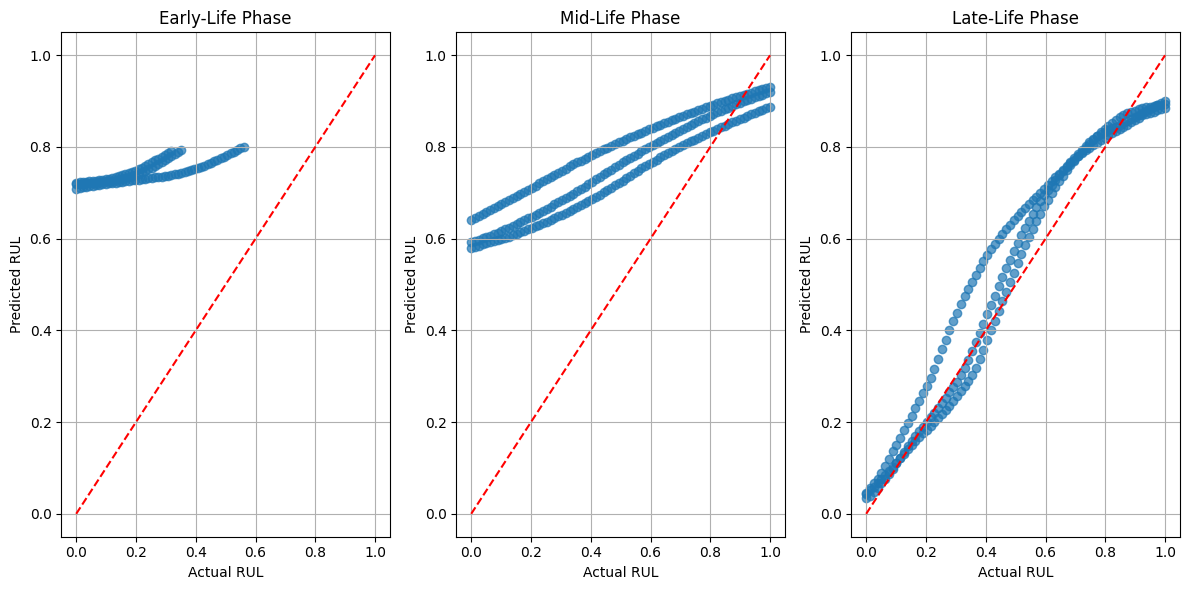

In [111]:
def compute_metrics_per_sample(y_true, y_pred, phase_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    sample_count = len(y_true)

    # Per-sample metrics
    mae_per_sample = mae / sample_count
    rmse_per_sample = rmse / sample_count

    print(f"{phase_name} Phase Per-Sample Metrics:")
    print(f"MAE per Sample: {mae_per_sample}, RMSE per Sample: {rmse_per_sample}")
    return mae_per_sample, rmse_per_sample

# Compute per-sample metrics for each phase
early_mae_sample, early_rmse_sample = compute_metrics_per_sample(y_early_test, y_pred_early_rescaled, "Early-Life")
mid_mae_sample, mid_rmse_sample = compute_metrics_per_sample(y_mid_test, y_pred_mid_rescaled, "Mid-Life")
late_mae_sample, late_rmse_sample = compute_metrics_per_sample(y_late_test, y_pred_late_rescaled, "Late-Life")

# Plot results for each phase
plt.figure(figsize=(12, 6))

# Early-life
plt.subplot(1, 3, 1)
plt.scatter(y_early_test, y_pred_early_rescaled, alpha=0.7)
plt.plot([0, 1], [0, 1], 'r--')
plt.title("Early-Life Phase")
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.grid(True)

# Mid-life
plt.subplot(1, 3, 2)
plt.scatter(y_mid_test, y_pred_mid_rescaled, alpha=0.7)
plt.plot([0, 1], [0, 1], 'r--')
plt.title("Mid-Life Phase")
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.grid(True)

# Late-life
plt.subplot(1, 3, 3)
plt.scatter(y_late_test, y_pred_late_rescaled, alpha=0.7)
plt.plot([0, 1], [0, 1], 'r--')
plt.title("Late-Life Phase")
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.grid(True)

plt.tight_layout()
plt.show()


Early-Life Phase Normalized Metrics:
NMAE: 2.399150479277338, NRMSE: 2.4668695552611632
Mid-Life Phase Normalized Metrics:
NMAE: 0.5484133362015591, NRMSE: 0.6596418103768434
Late-Life Phase Normalized Metrics:
NMAE: 0.11472524366329745, NRMSE: 0.1422864498616579


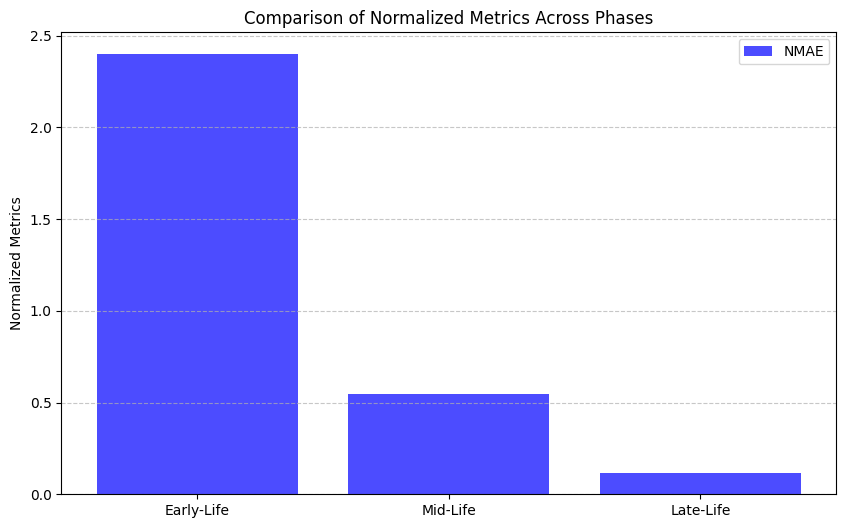

In [114]:
def compute_normalized_metrics(y_true, y_pred, phase_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mean_rul = np.mean(y_true)

    # Normalized metrics
    nmae = mae / mean_rul
    nrmse = rmse / mean_rul

    print(f"{phase_name} Phase Normalized Metrics:")
    print(f"NMAE: {nmae}, NRMSE: {nrmse}")
    return nmae, nrmse

# Compute normalized metrics for each phase
early_nmae, early_nrmse = compute_normalized_metrics(y_early_test, y_pred_early_rescaled, "Early-Life")
mid_nmae, mid_nrmse = compute_normalized_metrics(y_mid_test, y_pred_mid_rescaled, "Mid-Life")
late_nmae, late_nrmse = compute_normalized_metrics(y_late_test, y_pred_late_rescaled, "Late-Life")


import matplotlib.pyplot as plt

# Plot per-sample or normalized metrics
phases = ["Early-Life", "Mid-Life", "Late-Life"]
nmae_values = [early_nmae, mid_nmae, late_nmae]
nrmse_values = [early_nrmse, mid_nrmse, late_nrmse]

plt.figure(figsize=(10, 6))
plt.bar(phases, nmae_values, alpha=0.7, label="NMAE", color="blue")
plt.ylabel("Normalized Metrics")
plt.title("Comparison of Normalized Metrics Across Phases")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [115]:
def scale_back_rul(y_normalized, min_rul, max_rul):
    """Scale back normalized RUL values to their original range."""
    return y_normalized * (max_rul - min_rul) + min_rul

# Phase-specific RUL min and max values (from preprocessing)
early_min, early_max = y_early_test.min(), y_early_test.max()
mid_min, mid_max = y_mid_test.min(), y_mid_test.max()
late_min, late_max = y_late_test.min(), y_late_test.max()

# Scale back predictions and actual RUL for each phase
y_pred_early_original = scale_back_rul(y_pred_early_rescaled, early_min, early_max)
y_pred_mid_original = scale_back_rul(y_pred_mid_rescaled, mid_min, mid_max)
y_pred_late_original = scale_back_rul(y_pred_late_rescaled, late_min, late_max)

y_early_test_original = scale_back_rul(y_early_test, early_min, early_max)
y_mid_test_original = scale_back_rul(y_mid_test, mid_min, mid_max)
y_late_test_original = scale_back_rul(y_late_test, late_min, late_max)


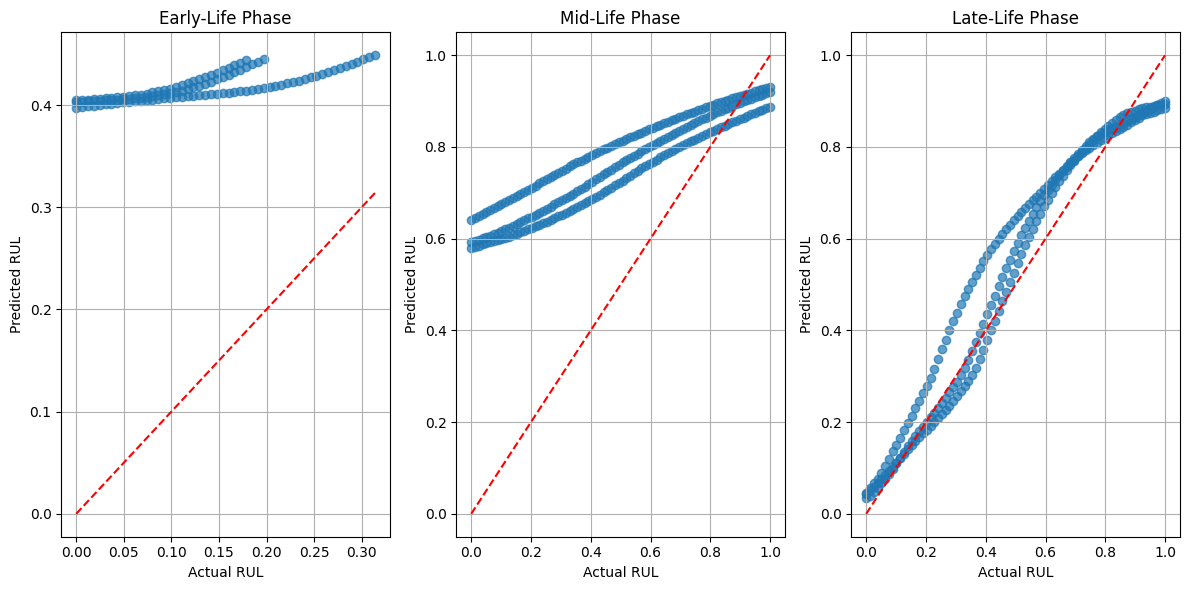

In [116]:
plt.figure(figsize=(12, 6))

# Early-life
plt.subplot(1, 3, 1)
plt.scatter(y_early_test_original, y_pred_early_original, alpha=0.7)
plt.plot([y_early_test_original.min(), y_early_test_original.max()],
         [y_early_test_original.min(), y_early_test_original.max()], 'r--')
plt.title("Early-Life Phase")
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.grid(True)

# Mid-life
plt.subplot(1, 3, 2)
plt.scatter(y_mid_test_original, y_pred_mid_original, alpha=0.7)
plt.plot([y_mid_test_original.min(), y_mid_test_original.max()],
         [y_mid_test_original.min(), y_mid_test_original.max()], 'r--')
plt.title("Mid-Life Phase")
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.grid(True)

# Late-life
plt.subplot(1, 3, 3)
plt.scatter(y_late_test_original, y_pred_late_original, alpha=0.7)
plt.plot([y_late_test_original.min(), y_late_test_original.max()],
         [y_late_test_original.min(), y_late_test_original.max()], 'r--')
plt.title("Late-Life Phase")
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.grid(True)

plt.tight_layout()
plt.show()


In [117]:
# Retrieve original min and max values for each phase
early_min, early_max = early_train["RUL80"].min(), early_train["RUL80"].max()
mid_min, mid_max = mid_train["RUL80"].min(), mid_train["RUL80"].max()
late_min, late_max = late_train["RUL80"].min(), late_train["RUL80"].max()

print(f"Early-Life Phase RUL Range: {early_min} - {early_max}")
print(f"Mid-Life Phase RUL Range: {mid_min} - {mid_max}")
print(f"Late-Life Phase RUL Range: {late_min} - {late_max}")


Early-Life Phase RUL Range: 805.0 - 1260.0
Mid-Life Phase RUL Range: 405.0 - 800.0
Late-Life Phase RUL Range: 5.0 - 400.0


In [118]:
def scale_back_rul(y_normalized, min_rul, max_rul):
    """Scale back normalized RUL values to their original range."""
    return y_normalized * (max_rul - min_rul) + min_rul

# Scale back predictions and actual RUL for each phase
y_pred_early_original = scale_back_rul(y_pred_early_rescaled, early_min, early_max)
y_pred_mid_original = scale_back_rul(y_pred_mid_rescaled, mid_min, mid_max)
y_pred_late_original = scale_back_rul(y_pred_late_rescaled, late_min, late_max)

y_early_test_original = scale_back_rul(y_early_test, early_min, early_max)
y_mid_test_original = scale_back_rul(y_mid_test, mid_min, mid_max)
y_late_test_original = scale_back_rul(y_late_test, late_min, late_max)


In [119]:
print("Early-Life Phase RUL Range:")
print(f"Original: {y_early_test_original.min()} - {y_early_test_original.max()}")
print(f"Predicted: {y_pred_early_original.min()} - {y_pred_early_original.max()}")

print("\nMid-Life Phase RUL Range:")
print(f"Original: {y_mid_test_original.min()} - {y_mid_test_original.max()}")
print(f"Predicted: {y_pred_mid_original.min()} - {y_pred_mid_original.max()}")

print("\nLate-Life Phase RUL Range:")
print(f"Original: {y_late_test_original.min()} - {y_late_test_original.max()}")
print(f"Predicted: {y_pred_late_original.min()} - {y_pred_late_original.max()}")


Early-Life Phase RUL Range:
Original: 805.0 - 1060.0
Predicted: 1127.63427734375 - 1169.361083984375

Mid-Life Phase RUL Range:
Original: 405.0 - 800.0
Predicted: 634.109130859375 - 772.9180297851562

Late-Life Phase RUL Range:
Original: 5.0 - 400.0
Predicted: 18.293312072753906 - 360.6390075683594


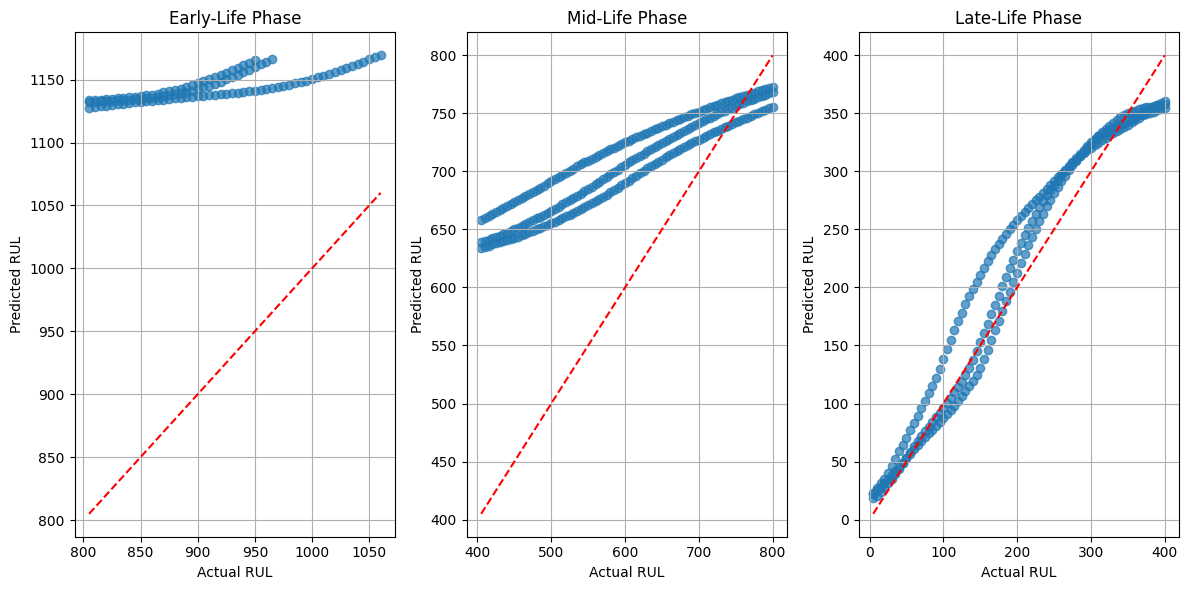

In [120]:
plt.figure(figsize=(12, 6))

# Early-life
plt.subplot(1, 3, 1)
plt.scatter(y_early_test_original, y_pred_early_original, alpha=0.7)
plt.plot([y_early_test_original.min(), y_early_test_original.max()],
         [y_early_test_original.min(), y_early_test_original.max()], 'r--')
plt.title("Early-Life Phase")
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.grid(True)

# Mid-life
plt.subplot(1, 3, 2)
plt.scatter(y_mid_test_original, y_pred_mid_original, alpha=0.7)
plt.plot([y_mid_test_original.min(), y_mid_test_original.max()],
         [y_mid_test_original.min(), y_mid_test_original.max()], 'r--')
plt.title("Mid-Life Phase")
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.grid(True)

# Late-life
plt.subplot(1, 3, 3)
plt.scatter(y_late_test_original, y_pred_late_original, alpha=0.7)
plt.plot([y_late_test_original.min(), y_late_test_original.max()],
         [y_late_test_original.min(), y_late_test_original.max()], 'r--')
plt.title("Late-Life Phase")
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.grid(True)

plt.tight_layout()
plt.show()


In [126]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Filter rows where RUL80 is valid
df_valid = df[df["RUL80"].notna()]

# Select 3 cells to hold back for testing
cells_to_hold_back = df_valid["Cell"].unique()[:3]  # Use the first 3 unique cells
df_test = df_valid[df_valid["Cell"].isin(cells_to_hold_back)]
df_train_val = df_valid[~df_valid["Cell"].isin(cells_to_hold_back)]

# Split remaining data into training and validation sets (80% train, 20% validation)
df_train, df_val = train_test_split(df_train_val, test_size=0.2, random_state=42, stratify=df_train_val["Cell"])

# Extract History (inputs) and RUL80 (targets) for training, validation, and testing
history_train = df_train["History"].tolist()
history_val = df_val["History"].tolist()
history_test = df_test["History"].tolist()

y_train = np.array(df_train["RUL80"])
y_val = np.array(df_val["RUL80"])
y_test = np.array(df_test["RUL80"])

In [127]:
# # Define thresholds for life phases
early_threshold = 800
mid_threshold = 400

# Early-life samples
early_train = df_train[df_train["RUL80"] > early_threshold]
early_val = df_val[df_val["RUL80"] > early_threshold]
early_test = df_test[df_test["RUL80"] > early_threshold]

# Mid-life samples
mid_train = df_train[(df_train["RUL80"] > mid_threshold) & (df_train["RUL80"] <= early_threshold)]
mid_val = df_val[(df_val["RUL80"] > mid_threshold) & (df_val["RUL80"] <= early_threshold)]
mid_test = df_test[(df_test["RUL80"] > mid_threshold) & (df_test["RUL80"] <= early_threshold)]

# Late-life samples
late_train = df_train[df_train["RUL80"] <= mid_threshold]
late_val = df_val[df_val["RUL80"] <= mid_threshold]
late_test = df_test[df_test["RUL80"] <= mid_threshold]


In [128]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def normalize_phase_data(train, val, test, max_seq_length=None):
    """
    Normalizes the input `History` and the target `RUL80` for a given phase (train, val, test).

    Args:
        train (pd.DataFrame): Training dataset for the phase.
        val (pd.DataFrame): Validation dataset for the phase.
        test (pd.DataFrame): Test dataset for the phase.
        max_seq_length (int): Maximum sequence length for padding. If None, it will be determined from the train data.

    Returns:
        dict: A dictionary containing normalized inputs and targets for train, val, and test,
              along with scalers for reproducibility.
    """
    # Extract history and target (RUL80) from the datasets
    train_histories = train["History"].tolist()
    val_histories = val["History"].tolist()
    test_histories = test["History"].tolist()
    
    y_train = train["RUL80"].values
    y_val = val["RUL80"].values
    y_test = test["RUL80"].values

    # Normalize the `History` data using MinMaxScaler
    history_scaler = MinMaxScaler()
    all_histories = np.concatenate([np.array(h) for h in train_histories])  # Flatten all train histories
    history_scaler.fit(all_histories.reshape(-1, 1))  # Fit scaler on train histories

    train_histories_normalized = [history_scaler.transform(np.array(h).reshape(-1, 1)).flatten() for h in train_histories]
    val_histories_normalized = [history_scaler.transform(np.array(h).reshape(-1, 1)).flatten() for h in val_histories]
    test_histories_normalized = [history_scaler.transform(np.array(h).reshape(-1, 1)).flatten() for h in test_histories]

    # Determine max sequence length for padding
    if max_seq_length is None:
        max_seq_length = max(len(h) for h in train_histories)

    # Pad all histories to the same max sequence length
    train_padded = pad_sequences(train_histories_normalized, maxlen=max_seq_length, padding='post', dtype='float32')
    val_padded = pad_sequences(val_histories_normalized, maxlen=max_seq_length, padding='post', dtype='float32')
    test_padded = pad_sequences(test_histories_normalized, maxlen=max_seq_length, padding='post', dtype='float32')

    # Reshape for LSTM input (samples, timesteps, features)
    X_train = train_padded[..., np.newaxis]
    X_val = val_padded[..., np.newaxis]
    X_test = test_padded[..., np.newaxis]

    # Normalize the `RUL80` targets using min-max scaling
    target_min = y_train.min()  # Use training data to determine min/max
    target_max = y_train.max()

    y_train_normalized = (y_train - target_min) / (target_max - target_min)
    y_val_normalized = (y_val - target_min) / (target_max - target_min)
    y_test_normalized = (y_test - target_min) / (target_max - target_min)

    return {
        "X_train": X_train,
        "y_train": y_train_normalized,
        "X_val": X_val,
        "y_val": y_val_normalized,
        "X_test": X_test,
        "y_test": y_test_normalized,
        "history_scaler": history_scaler,  # To invert normalization for History
        "target_min": target_min,         # To invert normalization for RUL80
        "target_max": target_max,
        "max_seq_length": max_seq_length  # Useful for ensuring consistent padding later
    }




In [129]:
early_phase = normalize_phase_data(early_train, early_val, early_test)
mid_phase = normalize_phase_data(mid_train, mid_val, mid_test)
late_phase = normalize_phase_data(late_train, late_val, late_test)



In [130]:
X_train_lstm = early_phase["X_train"]
y_train = early_phase["y_train"]
X_val_lstm = early_phase["X_val"]
y_val = early_phase["y_val"]
X_test_lstm = early_phase["X_test"]
y_test = early_phase["y_test"]


# Print shapes
print(f"X_train shape: {X_train_lstm.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val_lstm.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test_lstm.shape}, y_test shape: {y_test.shape}")



X_train shape: (1567, 112, 1), y_train shape: (1567,)
X_val shape: (381, 112, 1), y_val shape: (381,)
X_test shape: (115, 112, 1), y_test shape: (115,)


In [131]:
def build_model():
    model = Sequential([
        Masking(mask_value=0.0, input_shape=(max_sequence_length, 1)),
        LSTM(32, activation='tanh', return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)  # Single output
    ])
    model.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss='mse', metrics=['mae'])
    return model

# Train models for each phase
early_model = build_model()

X_early_train = early_phase["X_train"]
y_early_train = early_phase["y_train"]
X_early_val = early_phase["X_val"]
y_early_val = early_phase["y_val"]


# Early-life model
early_history = early_model.fit(
    X_early_train, y_early_train,
    validation_data=(X_early_val, y_early_val),
    epochs=20, batch_size=32, verbose=1
)

Epoch 1/20


/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0932 - mae: 0.2338 - val_loss: 0.0379 - val_mae: 0.1574
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0422 - mae: 0.1650 - val_loss: 0.0367 - val_mae: 0.1562
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0415 - mae: 0.1657 - val_loss: 0.0362 - val_mae: 0.1551
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0401 - mae: 0.1612 - val_loss: 0.0360 - val_mae: 0.1571
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0391 - mae: 0.1611 - val_loss: 0.0355 - val_mae: 0.1557
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0392 - mae: 0.1608 - val_loss: 0.0354 - val_mae: 0.1549
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0366 - mae: 0.1545 - val_loss: 0.0349 - val_mae: 0.1533
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0353 - mae: 0.1515 - val_loss: 0.0351 - val_mae: 0.1548
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0391 - mae: 0.

In [132]:
y_pred_early = early_model.predict(X_early_test).flatten()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


In [137]:
y_early_test

array([0.56043956, 0.54945055, 0.53846154, 0.52747253, 0.51648352,
       0.50549451, 0.49450549, 0.48351648, 0.47252747, 0.46153846,
       0.45054945, 0.43956044, 0.42857143, 0.41758242, 0.40659341,
       0.3956044 , 0.38461538, 0.37362637, 0.36263736, 0.35164835,
       0.34065934, 0.32967033, 0.31868132, 0.30769231, 0.2967033 ,
       0.28571429, 0.27472527, 0.26373626, 0.25274725, 0.24175824,
       0.23076923, 0.21978022, 0.20879121, 0.1978022 , 0.18681319,
       0.17582418, 0.16483516, 0.15384615, 0.14285714, 0.13186813,
       0.12087912, 0.10989011, 0.0989011 , 0.08791209, 0.07692308,
       0.06593407, 0.05494505, 0.04395604, 0.03296703, 0.02197802,
       0.01098901, 0.        , 0.35164835, 0.34065934, 0.32967033,
       0.31868132, 0.30769231, 0.2967033 , 0.28571429, 0.27472527,
       0.26373626, 0.25274725, 0.24175824, 0.23076923, 0.21978022,
       0.20879121, 0.1978022 , 0.18681319, 0.17582418, 0.16483516,
       0.15384615, 0.14285714, 0.13186813, 0.12087912, 0.10989

In [134]:
early_max = early_phase["target_max"]
early_min = early_phase["target_min"]

y_pred_early_rescaled = (y_pred_early * (early_max - early_min)) + early_min


In [138]:
y_early_test_rescaled = (y_early_test * (early_max - early_min)) + early_min

In [140]:
def evaluate_model(y_true, y_pred, phase):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{phase} Phase Metrics:")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"R² Score: {r2}")
    return mae, rmse, r2

# Evaluate each model
early_mae, early_rmse, early_r2 = evaluate_model(y_early_test_rescaled, y_pred_early_rescaled, "Early-Life")

Early-Life Phase Metrics:
MAE: 46.57683636209236
RMSE: 51.15462751433562
R² Score: 0.3969292245109143


In [141]:
def compute_metrics_per_sample(y_true, y_pred, phase_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    sample_count = len(y_true)

    # Per-sample metrics
    mae_per_sample = mae / sample_count
    rmse_per_sample = rmse / sample_count

    print(f"{phase_name} Phase Per-Sample Metrics:")
    print(f"MAE per Sample: {mae_per_sample}, RMSE per Sample: {rmse_per_sample}")
    return mae_per_sample, rmse_per_sample

# Compute per-sample metrics for each phase
early_mae_sample, early_rmse_sample = compute_metrics_per_sample(y_early_test_rescaled, y_pred_early_rescaled, "Early-Life")

Early-Life Phase Per-Sample Metrics:
MAE per Sample: 0.4050159683660205, RMSE per Sample: 0.44482284795074456


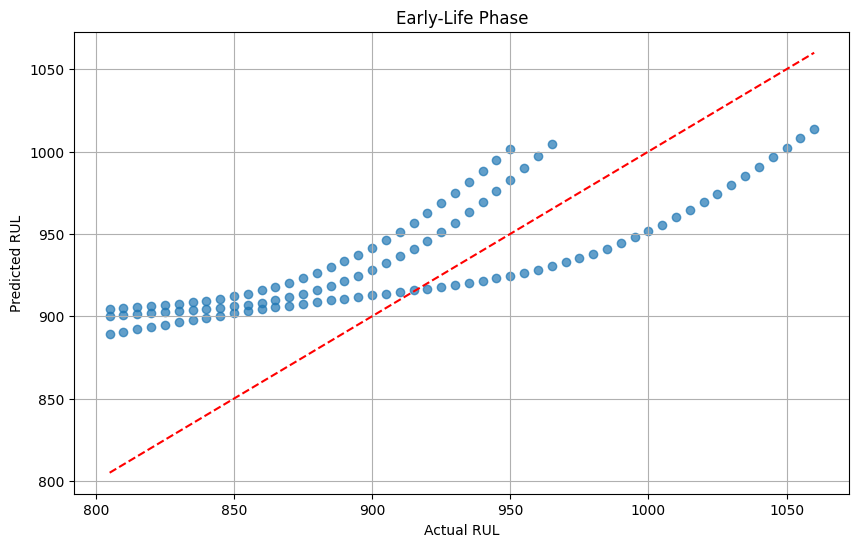

In [146]:
# Early-life

plt.figure(figsize=(10, 6))
plt.scatter(y_early_test_rescaled, y_pred_early_rescaled, alpha=0.7)
plt.plot([y_early_test_original.min(), y_early_test_original.max()],
         [y_early_test_original.min(), y_early_test_original.max()], 'r--')
plt.title("Early-Life Phase")
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.grid(True)

In [147]:
X_train_lstm = mid_phase["X_train"]
y_train = mid_phase["y_train"]
X_val_lstm = mid_phase["X_val"]
y_val = mid_phase["y_val"]
X_test_lstm = mid_phase["X_test"]
y_test = mid_phase["y_test"]


# Print shapes
print(f"X_train shape: {X_train_lstm.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val_lstm.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test_lstm.shape}, y_test shape: {y_test.shape}")



X_train shape: (2835, 192, 1), y_train shape: (2835,)
X_val shape: (685, 192, 1), y_val shape: (685,)
X_test shape: (240, 192, 1), y_test shape: (240,)


In [148]:
def build_model():
    model = Sequential([
        Masking(mask_value=0.0, input_shape=(max_sequence_length, 1)),
        LSTM(32, activation='tanh', return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)  # Single output
    ])
    model.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss='mse', metrics=['mae'])
    return model

# Train models for each phase
mid_model = build_model()

X_mid_train = mid_phase["X_train"]
y_mid_train = mid_phase["y_train"]
X_mid_val = mid_phase["X_val"]
y_mid_val = mid_phase["y_val"]


# Mid-life model
mid_history = mid_model.fit(
    X_mid_train, y_mid_train,
    validation_data=(X_mid_val, y_mid_val),
    epochs=20, batch_size=32, verbose=1
)

Epoch 1/20


/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.1170 - mae: 0.2639 - val_loss: 0.0346 - val_mae: 0.1481
Epoch 2/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0343 - mae: 0.1498 - val_loss: 0.0328 - val_mae: 0.1459
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0345 - mae: 0.1500 - val_loss: 0.0326 - val_mae: 0.1420
Epoch 4/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0316 - mae: 0.1415 - val_loss: 0.0320 - val_mae: 0.1410
Epoch 5/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0320 - mae: 0.1426 - val_loss: 0.0338 - val_mae: 0.1454
Epoch 6/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0326 - mae: 0.1436 - val_loss: 0.0334 - val_mae: 0.1432
Epoch 7/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0326 - mae: 0.1441 - val_loss: 0.0320 - val_mae: 0.1409
Epoch 8/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0309 - mae: 0.1397 - val_loss: 0.0353 - val_mae: 0.1486
Epoch 9/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0311 - mae: 0.

In [149]:
y_pred_mid = mid_model.predict(X_mid_test).flatten()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [152]:
y_mid_max = mid_phase["target_max"]
y_mid_min = mid_phase["target_min"]

y_pred_mid_rescaled = (y_pred_mid * (y_mid_max - y_mid_min)) + y_mid_min
y_mid_test_rescaled = (y_mid_test * (y_mid_max - y_mid_min)) + y_mid_min

In [154]:
def evaluate_model(y_true, y_pred, phase):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{phase} Phase Metrics:")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"R² Score: {r2}")
    return mae, rmse, r2

# Evaluate each model
mid_mae, mid_rmse, mid_r2 = evaluate_model(y_mid_test_rescaled, y_pred_mid_rescaled, "Early-Life")

Early-Life Phase Metrics:
MAE: 40.00947952270508
RMSE: 48.04555741942402
R² Score: 0.8268447754154209


In [155]:
mid_mae_sample, mid_rmse_sample = compute_metrics_per_sample(y_mid_test_rescaled, y_pred_mid_rescaled, "Mid-Life")

Mid-Life Phase Per-Sample Metrics:
MAE per Sample: 0.16670616467793783, RMSE per Sample: 0.20018982258093343


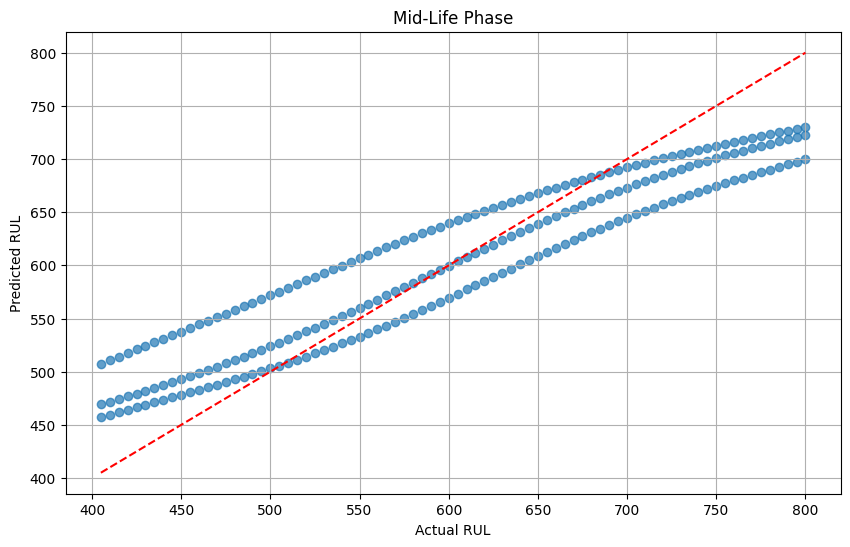

In [156]:


# Mid-life

plt.figure(figsize=(10, 6))
plt.scatter(y_mid_test_rescaled, y_pred_mid_rescaled, alpha=0.7)
plt.plot([y_mid_test_original.min(), y_mid_test_original.max()],
         [y_mid_test_original.min(), y_mid_test_original.max()], 'r--')
plt.title("Mid-Life Phase")
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.grid(True)
plt.show()

In [172]:

# Late-life

X_train_lstm = late_phase["X_train"]
y_train = late_phase["y_train"]
X_val_lstm = late_phase["X_val"]
y_val = late_phase["y_val"]
X_test_lstm = late_phase["X_test"]
y_test = late_phase["y_test"]


# Print shapes
print(f"X_train shape: {X_train_lstm.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val_lstm.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test_lstm.shape}, y_test shape: {y_test.shape}")


# Log-transform the target RUL80 values
y_train = np.log1p(y_train)
y_val = np.log1p(y_val)
y_test = np.log1p(y_test)


X_train shape: (2788, 272, 1), y_train shape: (2788,)
X_val shape: (732, 272, 1), y_val shape: (732,)
X_test shape: (240, 272, 1), y_test shape: (240,)


In [173]:
def build_model():
    model = Sequential([
        Masking(mask_value=0.0, input_shape=(max_sequence_length, 1)),
        LSTM(32, activation='tanh', return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)  # Single output   
    ])
    model.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss='mse', metrics=['mae'])
    return model


# Late-life model

late_model = build_model()

X_late_train = late_phase["X_train"]
y_late_train = late_phase["y_train"]
X_late_val = late_phase["X_val"]
y_late_val = late_phase["y_val"]

# Late-life model
late_history = late_model.fit(
    X_late_train, y_late_train,
    validation_data=(X_late_val, y_late_val),
    epochs=20, batch_size=32, verbose=1
)



Epoch 1/20


/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.1131 - mae: 0.2539 - val_loss: 0.0134 - val_mae: 0.0909
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0181 - mae: 0.1025 - val_loss: 0.0138 - val_mae: 0.0871
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0148 - mae: 0.0900 - val_loss: 0.0111 - val_mae: 0.0797
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0124 - mae: 0.0825 - val_loss: 0.0102 - val_mae: 0.0738
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0124 - mae: 0.0830 - val_loss: 0.0136 - val_mae: 0.0874
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0122 - mae: 0.0802 - val_loss: 0.0092 - val_mae: 0.0704
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0111 - mae: 0.0782 - val_loss: 0.0134 - val_mae: 0.0859
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0106 - mae: 0.0765 - val_loss: 0.0090 - val_mae: 0.0703
Epoch 9/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0105 - mae: 0.

In [174]:
y_pred_late = late_model.predict(X_late_test).flatten()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [175]:
# Invert the log transformation


y_late_max = late_phase["target_max"]
y_late_min = late_phase["target_min"]

y_pred_late_rescaled = (y_pred_late * (y_late_max - y_late_min)) + y_late_min
y_late_test_rescaled = (y_late_test * (y_late_max - y_late_min)) + y_late_min

late_mae, late_rmse, late_r2 = evaluate_model(y_late_test_rescaled, y_pred_late_rescaled, "Late-Life")

Late-Life Phase Metrics:
MAE: 87.85778933454885
RMSE: 127.51604039250861
R² Score: 0.5807404570530108


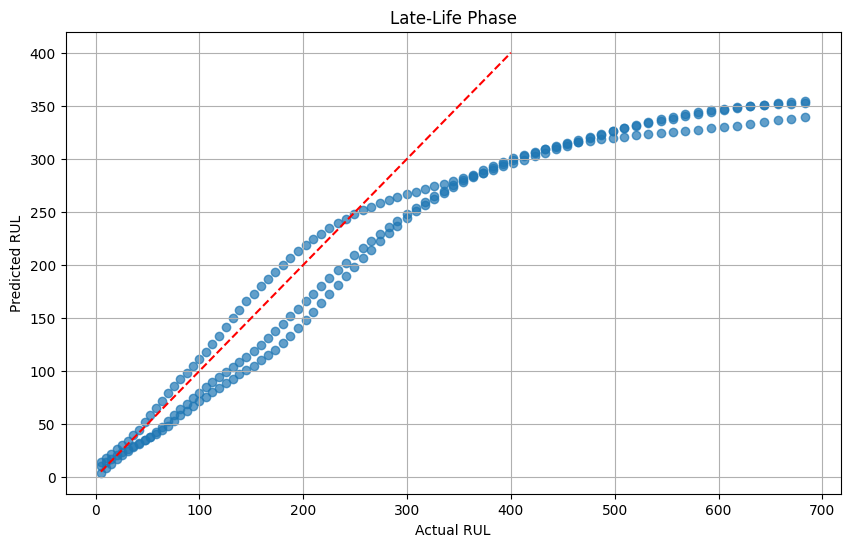

In [176]:

# Late-life

plt.figure(figsize=(10, 6))
plt.scatter(y_late_test_rescaled, y_pred_late_rescaled, alpha=0.7)
plt.plot([y_late_test_original.min(), y_late_test_original.max()],
         [y_late_test_original.min(), y_late_test_original.max()], 'r--')
plt.title("Late-Life Phase")
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.grid(True)
plt.show()
